In [1]:
import numpy as np
import pandas as pd
import pickle
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns

# open a file, where you stored the pickled data
file = open('raw_mod', 'rb')
# dump information to that file
turn_df = pickle.load(file)
# close the file
file.close()

# open a file, where you stored the pickled data
file = open('final', 'rb')
# dump information to that file
station_df = pickle.load(file)
# close the file
file.close()

OLD 99.0 percentile: 39899.07000000018
OLD 99.1 percentile: 42957.55700000009
NEW 99.0 percentile: 29348.0
NEW 99.1 percentile: 31109.765000000014


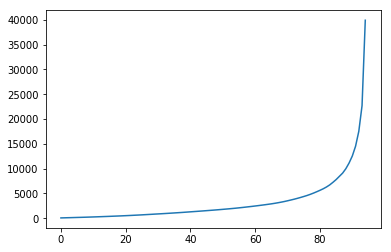

In [2]:
# Example of positive outlier
station_df[(station_df.STATION=='1 AV') 
           & (station_df.standard_time=='06:00:00')
           & (station_df.total_traffic>=10000)]

# Look at positive outliers to assess threshold
traffic_perc = [np.percentile(station_df['total_traffic'], i) for i in range(5,100)]
print('OLD 99.0 percentile: ' + str(np.percentile(station_df['total_traffic'], 99.0)))
print('OLD 99.1 percentile: ' + str(np.percentile(station_df['total_traffic'], 99.1)))

# 50,000 is a safe cutoff
plt.plot(traffic_perc);

# Cut off all observations more than 50,000
cutoff = 250000
remove_rows = list(station_df[station_df['total_traffic'] >= cutoff].index)
station_df.drop(remove_rows, inplace=True)

print('NEW 99.0 percentile: ' + str(np.percentile(station_df['total_traffic'], 99.0)))
print('NEW 99.1 percentile: ' + str(np.percentile(station_df['total_traffic'], 99.1)))

In [3]:
def is_weekend(day_of_week):
    if day_of_week <= 4:
        return 'weekday'
    else:
        return 'weekend'
    
station_df['is_weekend'] = station_df['day_of_week'].apply(is_weekend)

In [4]:
grp_station = station_df.groupby(by=['STATION']).agg(['sum','median','mean','std'])
grp_station_day = station_df.groupby(by=['STATION','DATE']).agg(['sum','mean'])
grp_station_time = station_df.groupby(by=['STATION','standard_time']).agg(['median','mean','std'])

In [5]:
grp_station_weekend = station_df.groupby(by=['STATION','is_weekend']).agg(['sum','mean'])
weekday_weekend_df = grp_station_weekend['total_traffic']
weekday_df = weekday_weekend_df.drop(index='weekend', level=1).reset_index()
weekend_df = weekday_weekend_df.drop(index='weekday', level=1).reset_index()

In [6]:
list(station_df[station_df['station_old']=='34 ST-PENN STA']['STATION'].unique())

['34 ST-PENN STA & 123', '34 ST-PENN STA & 123ACE', '34 ST-PENN STA & ACE']

In [7]:
weekday_weekend_df.xs('34 ST-PENN STA & 123')

,sum,mean
is_weekend,,
weekday,6461470.0,12425.903846
weekend,984519.0,4710.617225


In [8]:
weekday_weekend_df.xs('34 ST-PENN STA & 123ACE')

,sum,mean
is_weekend,,
weekday,14504328.0,32231.840000
weekend,2799165.0,15637.793296


In [9]:
weekday_weekend_df.xs('34 ST-PENN STA & ACE')

,sum,mean
is_weekend,,
weekday,14462280.0,28357.411765
weekend,3211862.0,15900.306931


In [10]:
weekend_df.sort_values(by='mean', ascending=False)[0:20]

,STATION,is_weekend,sum,mean
99,42 ST-PORT AUTH & ACENQRS1237W,weekend,3691994.0,21465.081395
86,34 ST-HERALD SQ & BDFMNQRW,weekend,3926499.0,20885.632979
307,GRD CNTRL-42 ST & 4567S,weekend,3681453.0,18593.196970
90,34 ST-PENN STA & ACE,weekend,3211862.0,15900.306931
89,34 ST-PENN STA & 123ACE,weekend,2799165.0,15637.793296
28,14 ST-UNION SQ & LNQR456W,weekend,2873120.0,14809.896907
430,TIMES SQ-42 ST & 1237ACENQRSW,weekend,2797163.0,14056.095477
284,FLUSHING-MAIN & 7,weekend,2618606.0,12836.303922
122,59 ST COLUMBUS & ABCD1,weekend,2490187.0,12029.888889
332,JKSN HT-ROOSVLT & EFMR7,weekend,2431988.0,11748.734300


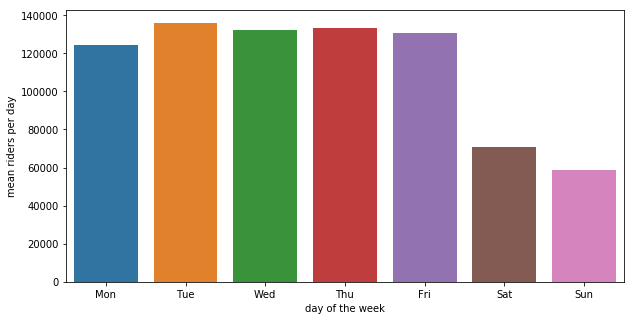

In [78]:
'''
Calculates the traffic by day of the week
'''

def filter_by_station_weekday(grp_obj, station_list):
    df = grp_obj[['total_traffic','day_of_week']].reset_index()
    df.columns = ['_'.join(col) for col in df.columns]
    df.drop(columns='total_traffic_mean', inplace=True)
    df.drop(columns='day_of_week_sum', inplace=True)
    df.rename(columns={'STATION_': 'STATION',
                       'DATE_': 'DATE',
                       'day_of_week_mean': 'day_of_week'}, inplace=True)
    df2 = df[df['STATION'].isin(station_list)]
    df_means = df2.groupby(by='day_of_week').mean()
    
    plt.figure(figsize=(10,5));
    ax = sns.barplot(x = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], 
                     y = df_means['total_traffic_sum'], ci='sd')
    ax.set(xlabel='day of the week', ylabel='mean riders per day');
    return df_means, df2, ax

grp_obj1 = station_df.groupby(by=['STATION','DATE']).agg(['sum','mean'])
station_list = list(station_df[station_df['station_old']=='34 ST-PENN STA']['STATION'].unique())
station_dayofweek_df, station_dayofweek_df2, myplot = filter_by_station_weekday(grp_obj1, station_list)

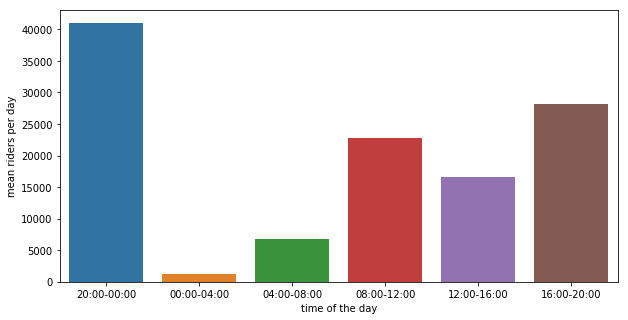

In [80]:
'''
Calculates the traffic by time of day
'''

def filter_by_station_time(grp_obj, station_list):
    df = grp_obj[['STATION','total_traffic','standard_time']].copy()
    df.columns = ['_'.join(col) for col in df.columns]
    df.drop(columns='total_traffic_sum', inplace=True)
    df.rename(columns={'STATION_': 'STATION',
                       'standard_time_': 'standard_time'}, inplace=True)
    df2 = df[df['STATION'].isin(station_list)]
    df_means = df2.groupby(by='standard_time').mean()
    
    plt.figure(figsize=(10,5));
    ax = sns.barplot(x = ['20:00-00:00','00:00-04:00','04:00-08:00','08:00-12:00','12:00-16:00','16:00-20:00'], 
                     y = df_means['total_traffic_mean'], ci='sd')
    ax.set(xlabel='time of the day', ylabel='mean riders per day');
    return df_means, df2, ax

grp_obj2 = station_df.groupby(by=['STATION','standard_time']).agg(['sum','mean']).reset_index()
station_timeofday_df, station_timeofday_df2, myplot2 = filter_by_station_time(grp_obj2, station_list)

In [81]:
stations_to_chk = ['GRD CNTRL-42 ST & 4567S',
 '34 ST-HERALD SQ & BDFMNQRW',
 '34 ST-PENN STA & ACE',
 '42 ST-PORT AUTH & ACENQRS1237W',
 '34 ST-PENN STA & 123ACE',
 'FULTON ST & 2345ACJZ',
 'TIMES SQ-42 ST & 1237ACENQRSW',
 '14 ST-UNION SQ & LNQR456W',
 '47-50 STS ROCK & BDFM',
 '59 ST COLUMBUS & ABCD1']

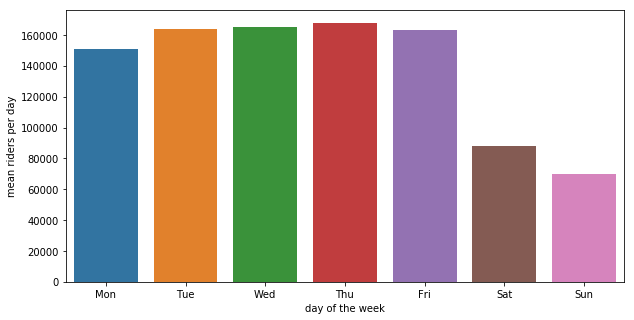

In [106]:
grp_obj1 = station_df.groupby(by=['STATION','DATE']).agg(['sum','mean'])
station_dayofweek_df, station_dayofweek_df2, myplot = filter_by_station_weekday(grp_obj1, stations_to_chk)
plt.savefig(fname='barchart_weekday', dpi=150)

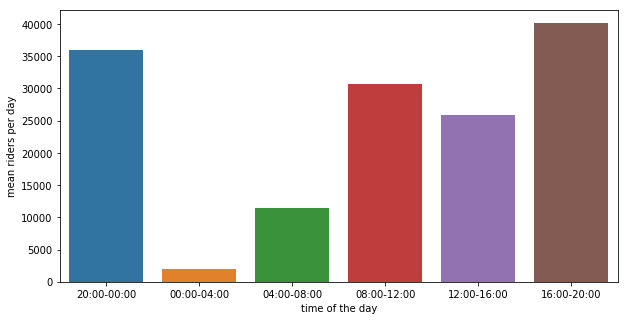

In [83]:
grp_obj2 = station_df.groupby(by=['STATION','standard_time']).agg(['sum','mean']).reset_index()
station_timeofday_df, station_timeofday_df2, myplot2 = filter_by_station_time(grp_obj2, stations_to_chk)

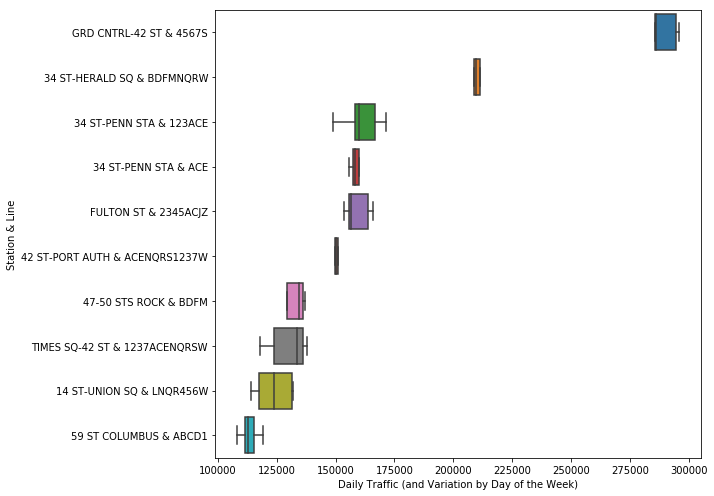

In [120]:
boxplot_df = station_dayofweek_df2[station_dayofweek_df2['day_of_week']<5].groupby(by=['STATION','day_of_week']).mean().reset_index()
order = boxplot_df.groupby(by='STATION').sum().sort_values(by='total_traffic_sum', ascending=False).index
plt.figure(figsize=(10,7));
ax0 = sns.boxplot(x='total_traffic_sum', y='STATION', data=boxplot_df, order=order, orient='h', showfliers=False);
ax0.set(xlabel='Daily Traffic (and Variation by Day of the Week)', ylabel='Station & Line')
plt.tight_layout()
plt.savefig(fname='box_plot_weekday', dpi=150)

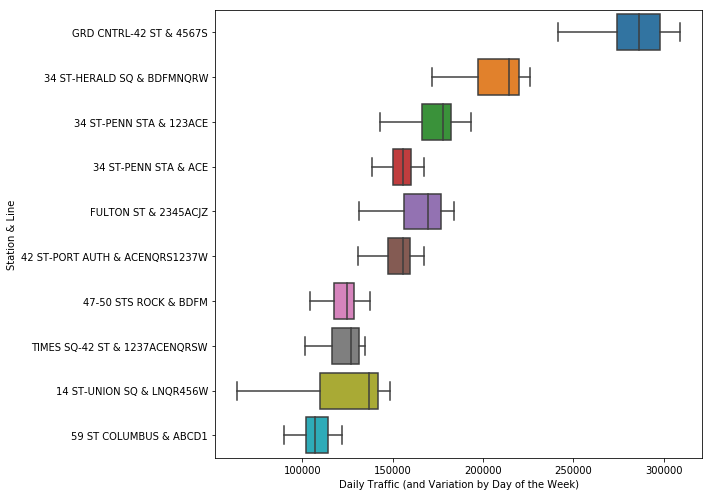

In [116]:
boxplot_df = station_dayofweek_df2[station_dayofweek_df2['day_of_week']<5].groupby(by=['STATION','DATE']).mean().reset_index()
order = boxplot_df.groupby(by='STATION').sum().sort_values(by='total_traffic_sum', ascending=False).index
plt.figure(figsize=(10,7));
ax1 = sns.boxplot(x='total_traffic_sum', y='STATION', data=boxplot_df, order=order, orient='h', showfliers=False);
ax1.set(xlabel='Daily Traffic (and Variation by Day of the Week)', ylabel='Station & Line')
plt.tight_layout()
plt.savefig(fname='box_plot_day', dpi=150)

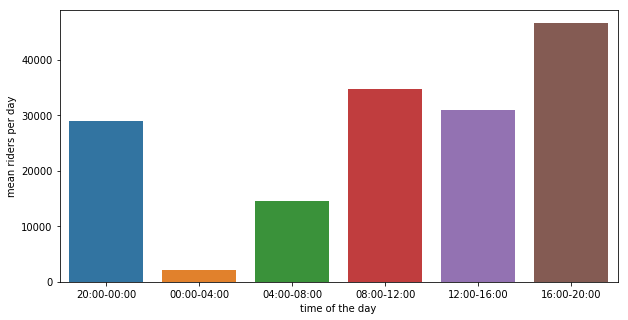

In [126]:
go_list = ['GRD CNTRL-42 ST & 4567S',
 '34 ST-HERALD SQ & BDFMNQRW',
 '34 ST-PENN STA & ACE',
 'FULTON ST & 2345ACJZ',
 '14 ST-UNION SQ & LNQR456W',
 '59 ST COLUMBUS & ABCD1']

 #'42 ST-PORT AUTH & ACENQRS1237W',
 #'34 ST-PENN STA & 123ACE',
 #'TIMES SQ-42 ST & 1237ACENQRSW',
 #'47-50 STS ROCK & BDFM',

time_dict = {'00:00:00': '20:00-00:00',
             '04:00:00': '00:00-04:00',
             '08:00:00': '04:00-08:00',
             '12:00:00': '08:00-12:00',
             '16:00:00': '12:00-16:00',
             '20:00:00': '16:00-20:00'}

grp_obj2 = station_df.groupby(by=['STATION','standard_time']).agg(['sum','mean']).reset_index()
station_timeofday_df, station_timeofday_df2, myplot2 = filter_by_station_time(grp_obj2, go_list)

def assign_time(time_str):
    return time_dict[time_str]

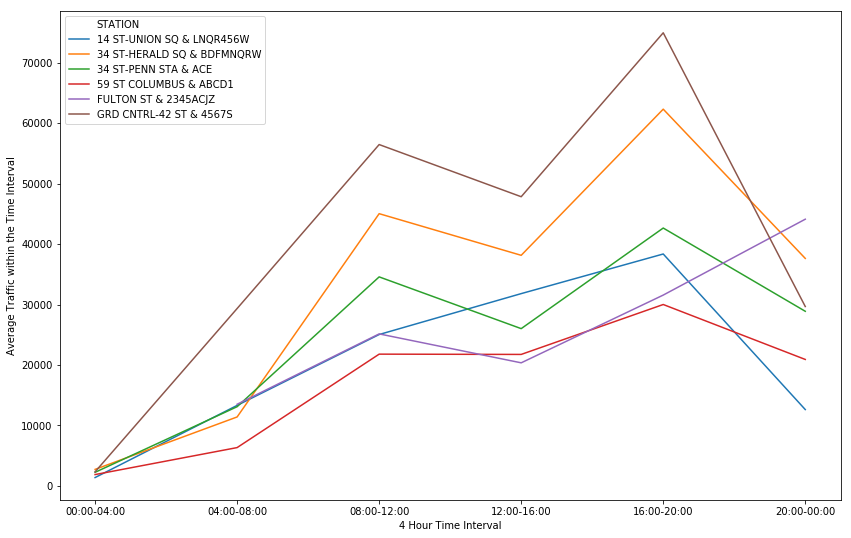

In [133]:
boxplot_df2 = station_timeofday_df2.groupby(by=['STATION','standard_time']).mean().reset_index()
boxplot_df2['time_bucket'] = boxplot_df2['standard_time'].apply(assign_time)
#order = boxplot_df2.groupby(by='STATION').sum().sort_values(by='total_traffic_mean', ascending=False).index

station_pivot = pd.pivot_table(data=boxplot_df2, values='total_traffic_mean', index='standard_time', columns='STATION', aggfunc='mean').reset_index()
plt.figure(figsize=(14,9));
ax2 = sns.lineplot(x='time_bucket', y='total_traffic_mean', data=boxplot_df2, hue='STATION')
ax2.set(xlabel='4 Hour Time Interval', ylabel='Average Traffic within the Time Interval');
plt.savefig(fname='line_plot_time', dpi=150)